## **Addressing data scarcity and class imbalance in Alzheimer's Disease**

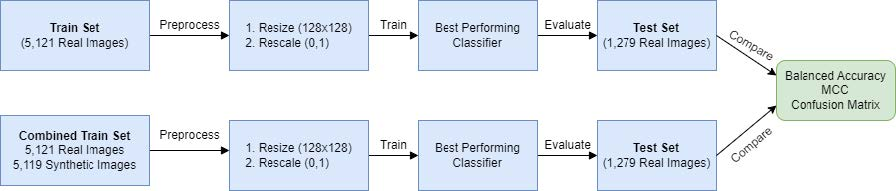[](http://)

#### **Why Balanced Accuracy, Matthews Correlation Coefficient and Confusion Matrix are more appropriate than F1 score for severely imbalanced datasets ?**
• F1 score may be misleading for heavily imbalanced datasets as it's biased towards the majority class due to equal weighting of precision and recall, regardless of class balance. Thus, a high F1 score does not necessarily indicate good performance on the minority class.

• F1 score is insensitive to misclassified true negatives and prioritizes positive instances more as both precision and recall are calculated based on the positive instances. When working on a heavily imbalanced dataset where positives are as important as the negatives, Balanced Accuracy does much better than F1 score because balanced accuracy shows a fast decrease when there is a decrease in the correct predictions of true negatives.

• Matthew’s correlation coefficient takes into account all four categories of confusion matrix and scores high only if high percentage of both negative and positive instances are classified correctly, regardless of class balance or imbalance. It's unbiased towards any class and hence suitable for heavily imbalanced datasets.

• Confusion matrix enables us to compare the performance on the minority classes

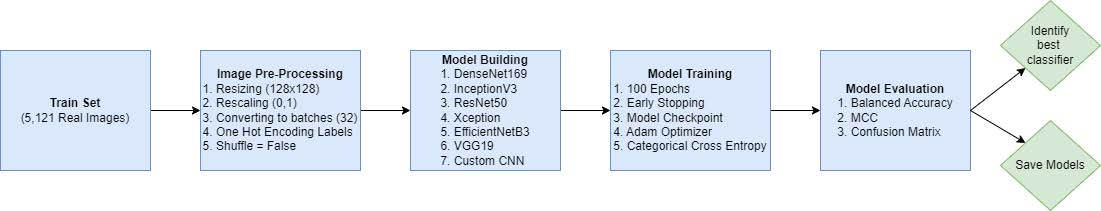

Custom CNN was found to be the best performing classifier amongst all other models as depicted in the image above. This is because all of the pretrained models used “ImageNet” weights and were too complex for this dataset due to which they could not generalise well on MRI data and ended up overfitting. On the other hand, the custom CNN was not a very complex architecture and was trained from scratch to only learn patterns specific to this use case.

#### **MODEL TRAINING**

1. All of the pretrained models and custom CNN were compiled with Adam as the optimizer with learning rate of 0.001, “Accuracy” and “F1 Score” as the metrics that will be computed after each epoch and “Categorical Cross Entropy” as the loss function since multiclass classification was being performed.

2. For callbacks, early stopping with patience = 10 and model checkpoint were implemented, both of which monitored validation loss. Early stopping was implemented to prevent the models from overfitting and patience was set to 10 because it’s a thumb rule in machine learning that patience should be 10% of the total epochs. 

3. Model checkpoint was implemented so that at the end of training each model will be loaded with those weights for which its validation loss was the minimum.

4. Finally, all of the pretrained models and the custom CNN were trained for 100 epochs by updating their weights using the training data and validating their performance after each epoch on the test data.

#### **MODEL EVALUATION**

After the models had been trained, they were evaluated on the fixed test dataset. Their resulting predictions (class probabilities from the output layer’s softmax activation function) were converted into class labels using the "numpy.argmax" function. After this step, using these class labels, the overall performance of each of these classifiers were compared by computing Balanced Accuracy and Matthews Correlation Coefficient which revealed the best performing classifier. Finally, the models were saved in ".h5" format for the sake of reproducibility of results.

#### **IMPORTING NECESSARY DEPENDENCIES**

In [1]:
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
from pathlib import Path
import tensorflow as tf
from random import randint
from tensorflow import keras
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from keras.utils.vis_utils import plot_model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from distutils.dir_util import copy_tree, remove_tree
from sklearn.metrics import balanced_accuracy_score as BAS
from tensorflow.keras.applications.resnet50 import ResNet50 
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.applications.inception_v3 import InceptionV3
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.efficientnet import EfficientNetB3
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, MaxPool2D, GlobalAveragePooling2D, ReLU, Softmax

/home/vkakarap/.conda/envs/akida_env/lib/python3.7/site-packages/tensorflow_addons/utils/ensure_tf_install.py:67: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.9.0 and strictly below 2.12.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.4 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


## Download Datasets here
- https://www.kaggle.com/datasets/lukechugh/best-alzheimer-mri-dataset-99-accuracy
- https://www.kaggle.com/datasets/lukechugh/best-alzheimer-mri-dataset-99-accuracy

#### **Setting the seed for reproducibility**

In [2]:
tf.random.set_seed(5638)
random.seed(5638)

#### **Defining Variables**

In [3]:
EPOCHS = 100
BATCH_SIZE = 32
IMG_SIZE = 128
IMAGE_SIZE = [128, 128]
DIM = (IMG_SIZE, IMG_SIZE)

#### **Custom CNN (Real MRIs Only)**

In [4]:
train_dir = Path('kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train/')

# Get filepaths and labels
filepaths = list(train_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
train_df = pd.concat([filepaths, labels], axis=1)

# Shuffle the DataFrame and reset index
train_df = train_df.sample(frac=1).reset_index(drop = True)

# Show the result
train_df.head(3)

,Filepath,Label
0,kaggle/input/alzheimers-dataset-4-class-of-ima...,NonDemented
1,kaggle/input/alzheimers-dataset-4-class-of-ima...,ModerateDemented
2,kaggle/input/alzheimers-dataset-4-class-of-ima...,NonDemented


In [5]:
test_dir = Path('kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/')

# Get filepaths and labels
filepaths = list(test_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
test_df = pd.concat([filepaths, labels], axis=1)

# Shuffle the DataFrame and reset index
test_df = test_df.sample(frac=1).reset_index(drop = True)

# Show the result
test_df.head(3)

,Filepath,Label
0,kaggle/input/alzheimers-dataset-4-class-of-ima...,VeryMildDemented
1,kaggle/input/alzheimers-dataset-4-class-of-ima...,VeryMildDemented
2,kaggle/input/alzheimers-dataset-4-class-of-ima...,VeryMildDemented


In [6]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1.0/255.0)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1.0/255.0)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(128,128),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    seed = 5638,
    shuffle=False
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(128, 128),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    seed = 5638,
    shuffle=False
)

CLASSES = list(test_images.class_indices.keys())

Found 5121 validated image filenames belonging to 4 classes.
Found 1279 validated image filenames belonging to 4 classes.


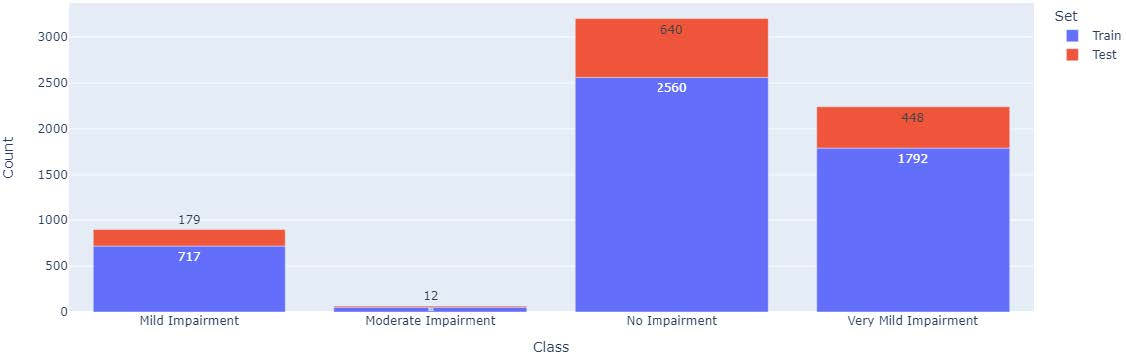

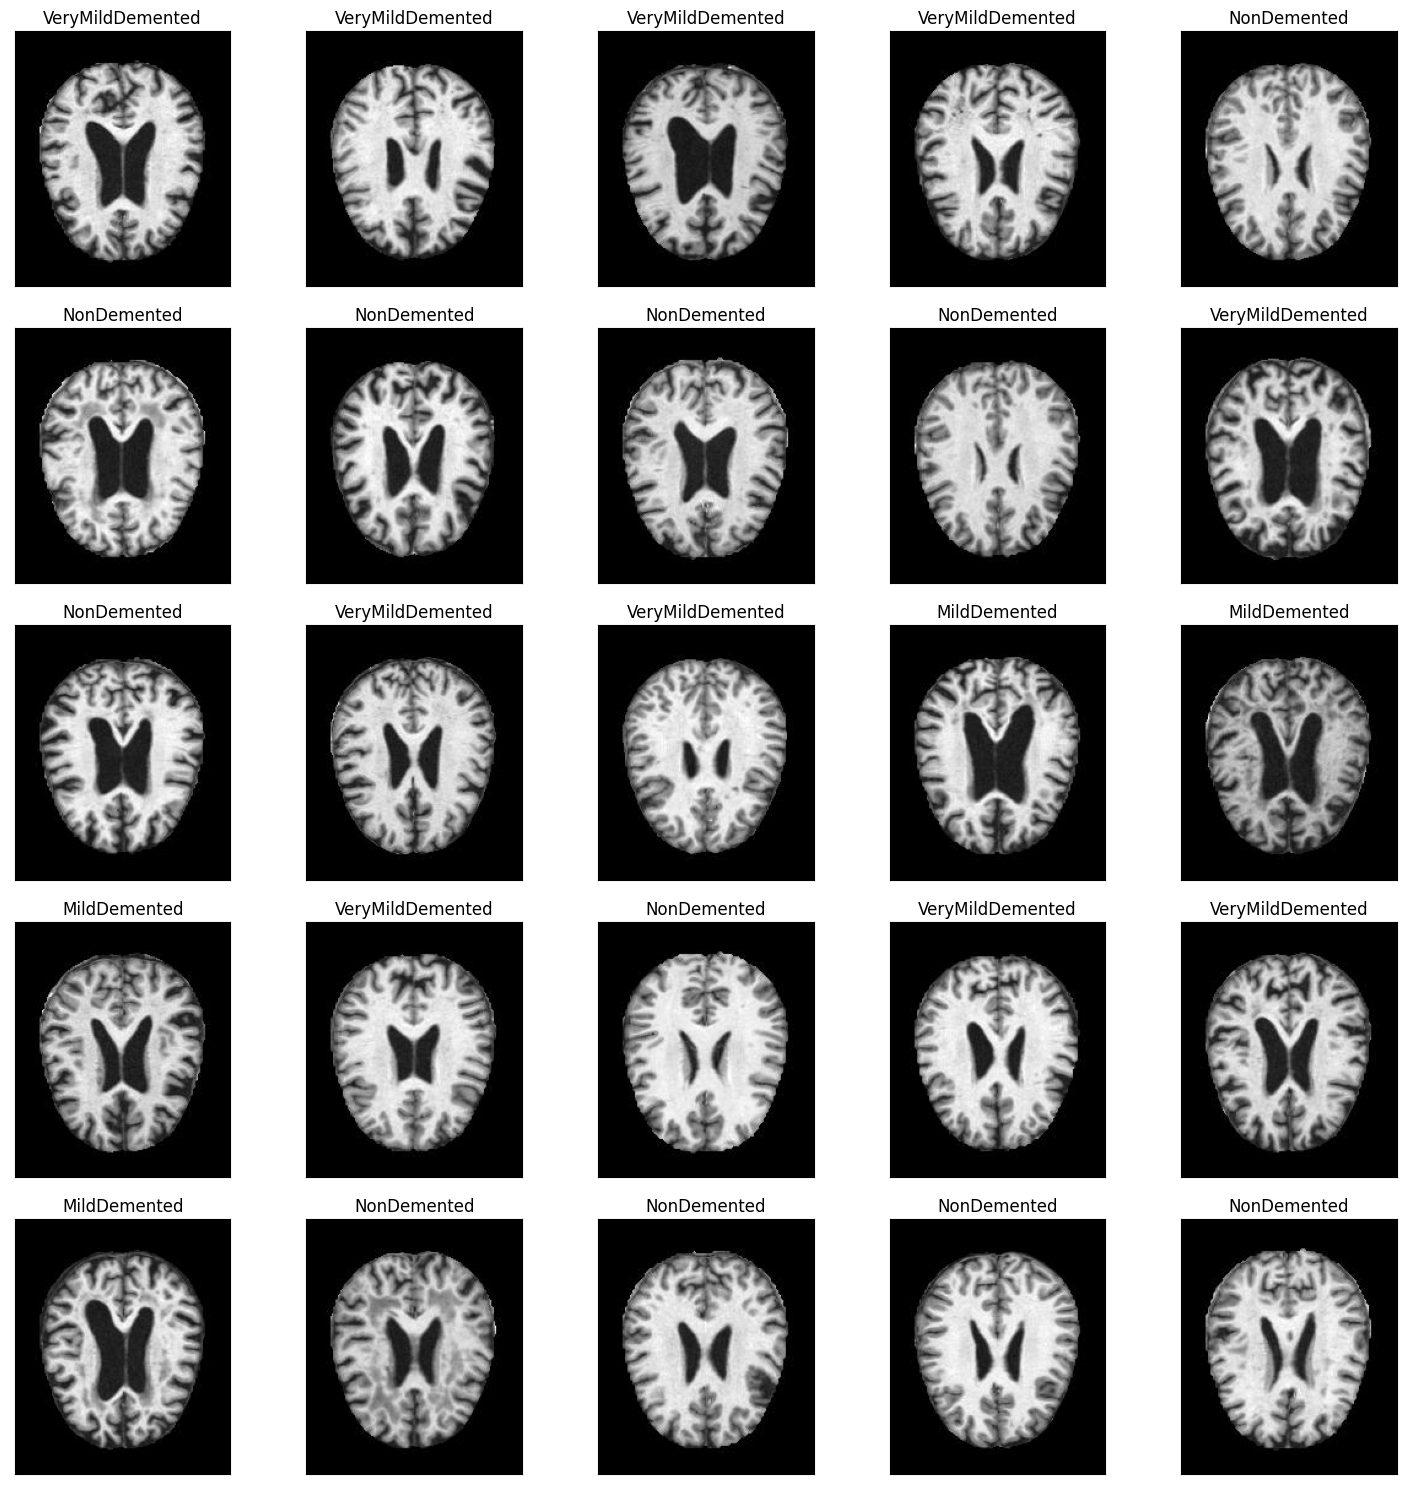

In [7]:
# Display 20 picture of the dataset with their labels
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath[i]), cmap = 'gray')
    ax.set_title(test_df.Label[i])
plt.tight_layout()
plt.show()

In [8]:
custom_model = Sequential([
    Input(shape=(*IMAGE_SIZE, 3)),
    Conv2D(16, 3, activation='relu', padding='same'),
    Conv2D(16, 3, activation='relu', padding='same'),
    MaxPool2D(padding='same'),
    Conv2D(32, 3, activation='relu', padding='same'),
    Conv2D(32, 3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPool2D(padding='same'),
    Conv2D(64, 3, activation='relu', padding='same'),
    Conv2D(64, 3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPool2D(padding='same'),
    Conv2D(128, 3, activation='relu', padding='same'),
    Conv2D(128, 3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPool2D(padding='same'),
    Conv2D(256, 3, activation='relu', padding='same'),
    Conv2D(256, 3, activation='relu', padding='same', name = 'last_conv_layer'),
    BatchNormalization(),
    MaxPool2D(padding='same'),
    Flatten(),
    Dropout(0.2),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.7),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(4, activation='softmax')        
], name = "cnn_model")

custom_model.summary()

OPT = tf.keras.optimizers.Adam(learning_rate=0.001)
METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'), tf.keras.metrics.AUC(name='auc'), tfa.metrics.F1Score(num_classes=4)]
custom_model.compile(optimizer='adam',loss=tf.losses.CategoricalCrossentropy(),metrics=METRICS)
earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 10, verbose = 1)
filepath = './best_weights.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor = 'val_loss', mode='min', save_best_only=True, verbose = 1)
callback_list = [earlystopping, checkpoint]
#Fit the training data to the model and validate it using the validation data
custom_model_history = custom_model.fit(train_images,validation_data=test_images, callbacks=callback_list, epochs=EPOCHS)

Model: "cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 32)       128       
 ormalization)                                           

2023-05-09 15:20:49.254466: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /packages/7x/jupyter/2022-04-15/lib
2023-05-09 15:20:49.254503: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-05-09 15:20:49.254842: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropri

Epoch 1/100
161/161 [==============================] - ETA: 0s - loss: 1.6054 - acc: 0.3679 - auc: 0.6248 - f1_score: 0.2638
Epoch 1: val_loss improved from inf to 3.09245, saving model to ./best_weights.hdf5
161/161 [==============================] - 25s 146ms/step - loss: 1.6054 - acc: 0.3679 - auc: 0.6248 - f1_score: 0.2638 - val_loss: 3.0925 - val_acc: 0.5004 - val_auc: 0.6733 - val_f1_score: 0.1668
Epoch 2/100
161/161 [==============================] - ETA: 0s - loss: 1.1607 - acc: 0.4921 - auc: 0.7652 - f1_score: 0.3192
Epoch 2: val_loss improved from 3.09245 to 1.18698, saving model to ./best_weights.hdf5
161/161 [==============================] - 20s 126ms/step - loss: 1.1607 - acc: 0.4921 - auc: 0.7652 - f1_score: 0.3192 - val_loss: 1.1870 - val_acc: 0.5004 - val_auc: 0.7941 - val_f1_score: 0.1668
Epoch 3/100
161/161 [==============================] - ETA: 0s - loss: 1.0208 - acc: 0.5325 - auc: 0.8132 - f1_score: 0.3358
Epoch 3: val_loss did not improve from 1.18698
161/161 [=

In [9]:
test_scores = custom_model.evaluate(test_images)
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))
pred_labels = custom_model.predict(test_images)

def roundoff(arr):
    """To round off according to the argmax of each predicted label array."""
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)
    
pred = np.argmax(pred_labels,axis=1)

print(classification_report(test_images.classes,pred,target_names=CLASSES))

40/40 [==============================] - 1s 28ms/step - loss: 1.7641 - acc: 0.4941 - auc: 0.7726 - f1_score: 0.4137
Testing Accuracy: 49.41%
                  precision    recall  f1-score   support

    MildDemented       0.30      0.77      0.43       179
ModerateDemented       0.22      0.17      0.19        12
     NonDemented       0.87      0.33      0.48       640
VeryMildDemented       0.49      0.62      0.55       448

        accuracy                           0.49      1279
       macro avg       0.47      0.47      0.41      1279
    weighted avg       0.65      0.49      0.50      1279



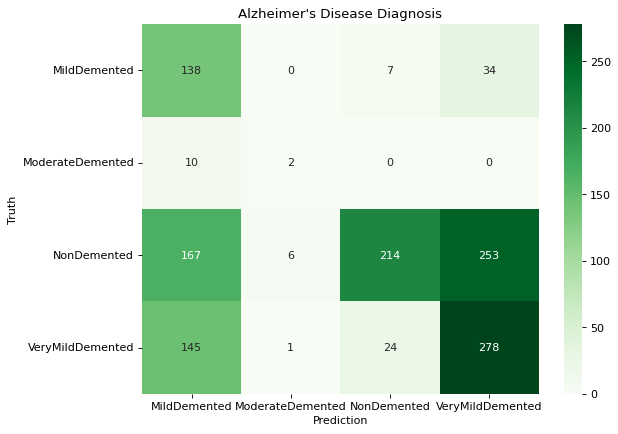

In [10]:
# Plot the confusion matrix to understand the classification in detail

test_ls, pred_ls = test_images.classes,pred
conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels=CLASSES, yticklabels=CLASSES)

plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [11]:
#Printing some other classification metrics
print("Balanced Accuracy Score: {} %".format(round(BAS(test_ls, pred_ls) * 100, 2)))
print("Matthew's Correlation Coefficient: {} %".format(round(MCC(test_ls, pred_ls) * 100, 2)))

Balanced Accuracy Score: 47.31 %
Matthew's Correlation Coefficient: 31.01 %


In [12]:
custom_model.save('custom_cnn_(87.04%).h5')

#### **Custom CNN (Real + Synthetic MRIs)**

In [13]:
train_dir = Path('kaggle/input/best-alzheimer-mri-dataset-99-accuracy/Combined Dataset/train/')

# Get filepaths and labels
filepaths = list(train_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
train_df = pd.concat([filepaths, labels], axis=1)

# Shuffle the DataFrame and reset index
train_df = train_df.sample(frac=1).reset_index(drop = True)

# Show the result
train_df.head(3)

,Filepath,Label
0,kaggle/input/best-alzheimer-mri-dataset-99-acc...,Moderate Impairment
1,kaggle/input/best-alzheimer-mri-dataset-99-acc...,Mild Impairment
2,kaggle/input/best-alzheimer-mri-dataset-99-acc...,Mild Impairment


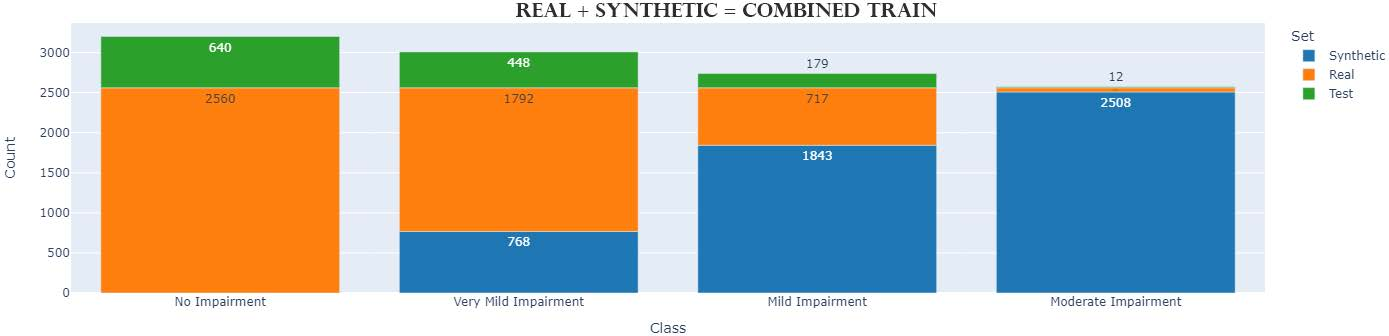

In [14]:
custom_model_combined = Sequential([
    Input(shape=(*IMAGE_SIZE, 3)),
    Conv2D(16, 3, padding='same', name="Conv2D_1"),
    ReLU(name="ReLU_1"),
    Conv2D(16, 3, padding='same', name="Conv2D_2"),
    ReLU(name="ReLU_2"),
    MaxPool2D(padding='same'),
    Conv2D(32, 3, padding='same', name="Conv2D_3"),
    ReLU(name="ReLU_3"),
    Conv2D(32, 3, padding='same', name="Conv2D_4"),
    BatchNormalization(),
    ReLU(name="ReLU_4"),
    MaxPool2D(padding='same'),
    Conv2D(64, 3, padding='same', name="Conv2D_5"),
    ReLU(name="ReLU_5"),
    Conv2D(64, 3, padding='same', name="Conv2D_6"),
    BatchNormalization(),
    ReLU(name="ReLU_6"),
    MaxPool2D(padding='same'),
    Conv2D(128, 3, padding='same', name="Conv2D_7"),
    ReLU(name="ReLU_7"),
    Conv2D(128, 3, padding='same', name="Conv2D_8"),
    BatchNormalization(),
    ReLU(name="ReLU_8"),
    MaxPool2D(padding='same'),
    Conv2D(256, 3, padding='same', name="Conv2D_9"),
    ReLU(name="ReLU_9"),
    Conv2D(256, 3, padding='same', name = 'last_conv_layer'),
    BatchNormalization(),
    ReLU(name="ReLU_10"),
    MaxPool2D(padding='same'),
    Flatten(),
    Dropout(0.2),
    Dense(512, name="Dense_1"),
    BatchNormalization(),
    ReLU(name="ReLU_11"),
    Dropout(0.7),
    Dense(128, name="Dense_2"),
    BatchNormalization(),
    ReLU(name="ReLU_12"),
    Dropout(0.5),
    Dense(64, name="Dense_3"),
    BatchNormalization(),
    ReLU(name="ReLU_13"),
    Dropout(0.3),
    Dense(4, name="Dense_4"),
    Softmax()
], name = "cnn_model")

custom_model_combined.summary(line_length=100)

Model: "cnn_model"
____________________________________________________________________________________________________
 Layer (type)                                Output Shape                            Param #        
 Conv2D_1 (Conv2D)                           (None, 128, 128, 16)                    448            
                                                                                                    
 ReLU_1 (ReLU)                               (None, 128, 128, 16)                    0              
                                                                                                    
 Conv2D_2 (Conv2D)                           (None, 128, 128, 16)                    2320           
                                                                                                    
 ReLU_2 (ReLU)                               (None, 128, 128, 16)                    0              
                                                                        

In [15]:
OPT = tf.keras.optimizers.Adam(learning_rate=0.001)

METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc'), 
           tfa.metrics.F1Score(num_classes=4)]

custom_model_combined.compile(optimizer='adam',
                              loss=tf.losses.CategoricalCrossentropy(),
                              metrics=METRICS)

In [16]:
earlystopping = EarlyStopping(monitor = 'val_loss', 
                              mode = 'min', 
                              patience = 20,
                              verbose = 1)

filepath = './best_weights.hdf5'

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_loss', 
                                mode='min', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

In [17]:
#Fit the training data to the model and validate it using the validation data
custom_model_combined_history = custom_model_combined.fit(train_images,validation_data=test_images, callbacks=callback_list, epochs=EPOCHS)

Epoch 1/100
161/161 [==============================] - ETA: 0s - loss: 1.2674 - acc: 0.4357 - auc: 0.7150 - f1_score: 0.2884
Epoch 1: val_loss improved from inf to 2.46287, saving model to ./best_weights.hdf5
161/161 [==============================] - 22s 129ms/step - loss: 1.2674 - acc: 0.4357 - auc: 0.7150 - f1_score: 0.2884 - val_loss: 2.4629 - val_acc: 0.5106 - val_auc: 0.7329 - val_f1_score: 0.1878
Epoch 2/100
161/161 [==============================] - ETA: 0s - loss: 1.0097 - acc: 0.5159 - auc: 0.8099 - f1_score: 0.3148
Epoch 2: val_loss improved from 2.46287 to 1.31904, saving model to ./best_weights.hdf5
161/161 [==============================] - 21s 131ms/step - loss: 1.0097 - acc: 0.5159 - auc: 0.8099 - f1_score: 0.3148 - val_loss: 1.3190 - val_acc: 0.1407 - val_auc: 0.5739 - val_f1_score: 0.0689
Epoch 3/100
161/161 [==============================] - ETA: 0s - loss: 0.9338 - acc: 0.5378 - auc: 0.8317 - f1_score: 0.3362
Epoch 3: val_loss did not improve from 1.31904
161/161 [=

In [18]:
test_scores = custom_model_combined.evaluate(test_images)
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))
pred_labels = custom_model_combined.predict(test_images)

def roundoff(arr):
    """To round off according to the argmax of each predicted label array."""
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)
    
pred = np.argmax(pred_labels,axis=1)

print(classification_report(test_images.classes,pred,target_names=CLASSES))

40/40 [==============================] - 1s 29ms/step - loss: 3.2385 - acc: 0.3260 - auc: 0.5879 - f1_score: 0.2493
Testing Accuracy: 32.60%
                  precision    recall  f1-score   support

    MildDemented       0.19      0.93      0.32       179
ModerateDemented       0.04      0.25      0.06        12
     NonDemented       0.91      0.33      0.49       640
VeryMildDemented       0.40      0.08      0.13       448

        accuracy                           0.33      1279
       macro avg       0.38      0.40      0.25      1279
    weighted avg       0.62      0.33      0.33      1279



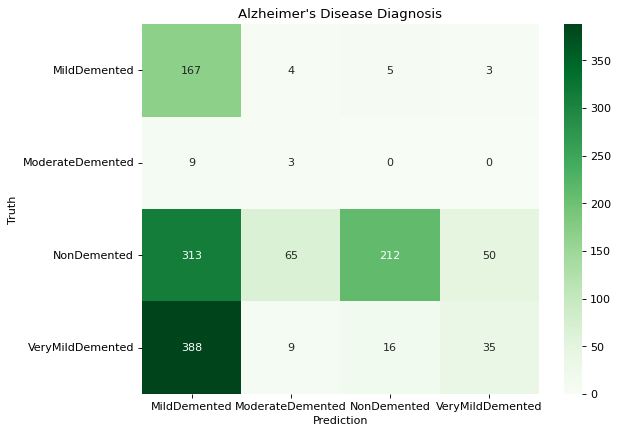

In [19]:
# Plot the confusion matrix to understand the classification in detail

test_ls, pred_ls = test_images.classes,pred
conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels=CLASSES, yticklabels=CLASSES)

plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [20]:
#Printing some other classification metrics
print("Balanced Accuracy Score: {} %".format(round(BAS(test_ls, pred_ls) * 100, 2)))
print("Matthew's Correlation Coefficient: {} %".format(round(MCC(test_ls, pred_ls) * 100, 2)))

Balanced Accuracy Score: 39.81 %
Matthew's Correlation Coefficient: 20.98 %


In [21]:
custom_model_combined.save('custom_cnn_(combined)_(98.81%).h5')

#### **GRAD-CAMs**

This was done by extracting the gradients from the last convolutional layer, for each image, which were then overlapped on top of that particular image in form of a heatmap to visualize which parts of the image did the classifier focussed on, in order to make its classification decisions.

The following figure will clearly illustrate the regions responsible for classification in a hierarchy using a colour-bar in which “red” indicates the region where the classifier focused the most followed by “orange”, “yellow”, “green” and finally “blue” indicating the regions where it focussed the least. These images were classified with 100% accuracy which can also be seen by the ground truth and the predicted label on top of each image.

Researchers and medical professionals can benefit from using grad-cams (explainable AI) to identify the indicators of Alzheimer’s for each stage. Additionally, in the future, if an application is developed that automates the diagnosis of Alzheimer’s disease, clinicians could then utilize the grad-cam feature in the application to interpret and confirm the classification decisions for each person's MRI

In [22]:
def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size "size"
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
                                      
    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    # display(Image(cam_path))
    
    return cam_path

import matplotlib.cm as cm
img_size = IMAGE_SIZE

# Remove last layer's softmax
custom_model_combined.layers[-1].activation = None

last_conv_layer_name = "last_conv_layer"

In [23]:
pred_labels = custom_model_combined.predict(test_images)

def roundoff(arr):
    """To round off according to the argmax of each predicted label array."""
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)
    
pred = np.argmax(pred_labels,axis=1)

# Map the label to respective classes
labels = (test_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

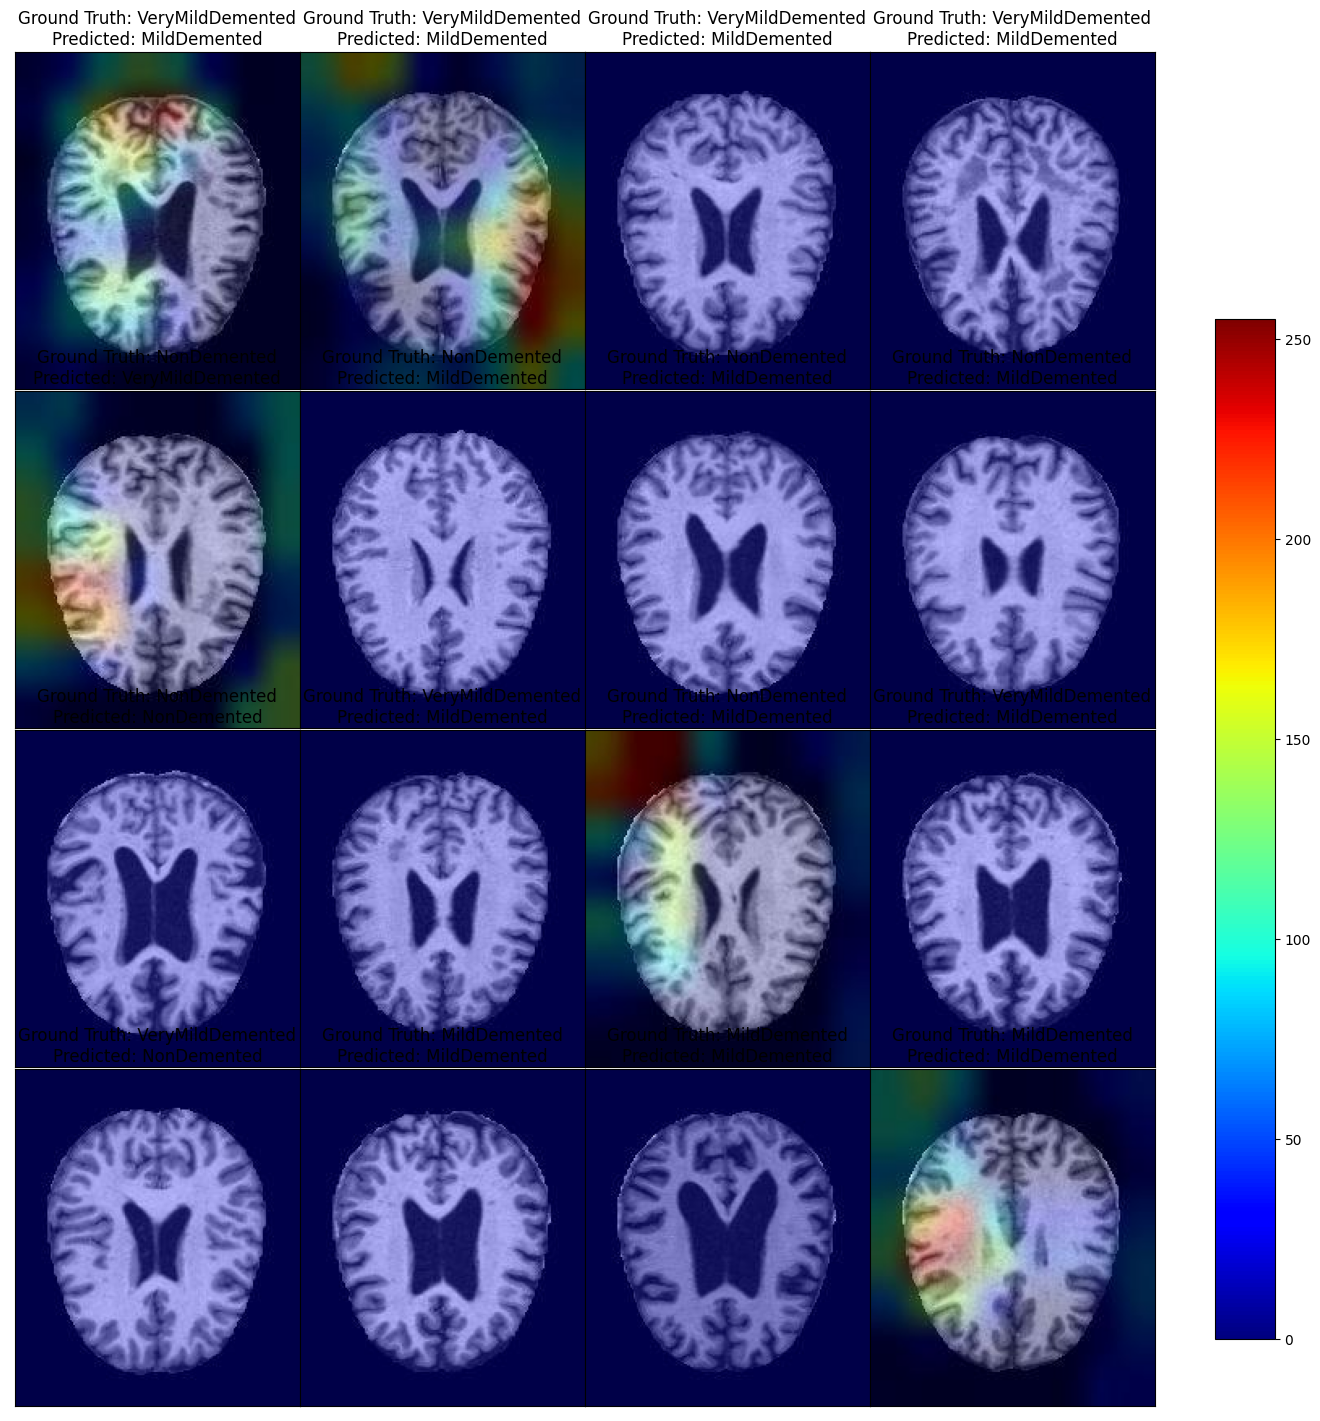

In [24]:
# Display the part of the pictures used by the neural network to classify the pictures
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 12), subplot_kw={'xticks': [], 'yticks': []})
                        
for i, ax in enumerate(axes.flat):
    img_path = test_df.Filepath.iloc[i+250]
    img_array = get_img_array(img_path, size=img_size)
    heatmap = make_gradcam_heatmap(img_array, custom_model_combined, last_conv_layer_name)
    cam_path = save_and_display_gradcam(img_path, heatmap)
    cbar = ax.imshow(plt.imread(cam_path),cmap='jet')
    ax.set_title(f"Ground Truth: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
cbar_ax = fig.add_axes([1.0, 0.057, 0.05, 0.85])
plt.colorbar(cbar, cax=cbar_ax)
plt.savefig("grad_cam.jpg")
plt.subplots_adjust(left=0, bottom=0, right=1, top=1.13, wspace=0, hspace=0)
plt.subplots_adjust(right=0.95)
plt.show()

## CNN2SNN

In [25]:
from cnn2snn import check_model_compatibility

print("Model compatible for Akida conversion:",
      check_model_compatibility(custom_model_combined))

Model compatible for Akida conversion: True


In [26]:
from cnn2snn import quantize

model_quantized = quantize(custom_model_combined,
                           input_weight_quantization=8,
                           weight_quantization=8,
                           activ_quantization=8)
model_quantized.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv2D_1 (QuantizedConv2D)  (None, 128, 128, 16)      448       
                                                                 
 ReLU_1 (QuantizedReLU)      (None, 128, 128, 16)      0         
                                                                 
 Conv2D_2 (QuantizedConv2D)  (None, 128, 128, 16)      2320      
                                                                 
 ReLU_2 (QuantizedReLU)      (None, 128, 128, 16)      0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 64, 64, 16)       0         
 2D)                                                             
                                                                 
 Conv2D_3 (QuantizedConv2D)  (None, 64, 64, 32)        4640      
                                                      

In [28]:
model_quantized.compile(
    loss=keras.losses.CategoricalCrossentropy(),
    optimizer='adam',
    metrics=METRICS)

test_scores = model_quantized.evaluate(test_images)
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))
print('Test accuracy after 8-8-8 quantization:', test_scores[1])

40/40 [==============================] - 2s 39ms/step - loss: 11.4074 - acc: 0.2213 - auc: 0.4595 - f1_score: 0.1706
Testing Accuracy: 22.13%
Test accuracy after 8-8-8 quantization: 0.22126661241054535


In [29]:
model_quantized = quantize(custom_model_combined,
                           input_weight_quantization=8,
                           weight_quantization=4,
                           activ_quantization=2)
model_quantized.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv2D_1 (QuantizedConv2D)  (None, 128, 128, 16)      448       
                                                                 
 ReLU_1 (QuantizedReLU)      (None, 128, 128, 16)      0         
                                                                 
 Conv2D_2 (QuantizedConv2D)  (None, 128, 128, 16)      2320      
                                                                 
 ReLU_2 (QuantizedReLU)      (None, 128, 128, 16)      0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 64, 64, 16)       0         
 2D)                                                             
                                                                 
 Conv2D_3 (QuantizedConv2D)  (None, 64, 64, 32)        4640      
                                                      

In [30]:
model_quantized.compile(
    loss=keras.losses.CategoricalCrossentropy(),
    optimizer='adam',
    metrics=METRICS)

test_scores = model_quantized.evaluate(test_images)
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))
print('Test accuracy after 8-8-8 quantization:', test_scores[1])

40/40 [==============================] - 2s 34ms/step - loss: 3.6040 - acc: 0.2535 - auc: 0.4766 - f1_score: 0.1980
Testing Accuracy: 25.35%
Test accuracy after 8-8-8 quantization: 0.25351837277412415


In [32]:
from cnn2snn import quantize_layer

model_quantized = quantize_layer(model_quantized, "ReLU_1", bitwidth=1)
model_quantized = quantize_layer(model_quantized, "Dense_4", bitwidth=2)

model_quantized.compile(
    loss=keras.losses.CategoricalCrossentropy(),
    optimizer='adam',
    metrics=METRICS)

score = model_quantized.evaluate(test_images, verbose=0)
print('Test accuracy after low bitwidth quantization:', score[1])

# To recover the original model accuracy, a quantization-aware training phase is required.

Test accuracy after low bitwidth quantization: 0.27286943793296814


In [33]:
model_quantized.fit(train_images,validation_data=test_images, callbacks=callback_list, epochs=EPOCHS)

score = model_quantized.evaluate(test_images, verbose=0)
print('Test accuracy after fine tuning:', score[1])

Epoch 1/100
161/161 [==============================] - ETA: 0s - loss: 1.1652 - acc: 0.4810 - auc: 0.7560 - f1_score: 0.2015
Epoch 1: val_loss improved from 1.25071 to 1.05329, saving model to ./best_weights.hdf5
161/161 [==============================] - 29s 161ms/step - loss: 1.1652 - acc: 0.4810 - auc: 0.7560 - f1_score: 0.2015 - val_loss: 1.0533 - val_acc: 0.5004 - val_auc: 0.7806 - val_f1_score: 0.1668
Epoch 2/100
161/161 [==============================] - ETA: 0s - loss: 1.0830 - acc: 0.4946 - auc: 0.7743 - f1_score: 0.1854
Epoch 2: val_loss improved from 1.05329 to 1.03585, saving model to ./best_weights.hdf5
161/161 [==============================] - 25s 158ms/step - loss: 1.0830 - acc: 0.4946 - auc: 0.7743 - f1_score: 0.1854 - val_loss: 1.0359 - val_acc: 0.5004 - val_auc: 0.7806 - val_f1_score: 0.1668
Epoch 3/100
161/161 [==============================] - ETA: 0s - loss: 1.0840 - acc: 0.4927 - auc: 0.7746 - f1_score: 0.1865
Epoch 3: val_loss did not improve from 1.03585
161/16

In [38]:
from cnn2snn import convert

target_size=(128, 128)

model_akida = convert(model_quantized, input_scaling=target_size)
model_akida.summary()

accuracy = model_akida.evaluate(test_images)
print('Test accuracy after conversion:', accuracy)

# For non-regression purpose
assert accuracy > 0.50

                 Model Summary                  
________________________________________________
Input shape    Output shape  Sequences  Layers
[128, 128, 3]  [1, 1, 4]     1          14    
________________________________________________

               SW/Conv2D_1-Dense_4 (Software)               
____________________________________________________________
Layer (type)             Output shape    Kernel shape     
Conv2D_1 (InputConv.)    [128, 128, 16]  (3, 3, 3, 16)    
____________________________________________________________
Conv2D_2 (Conv.)         [64, 64, 16]    (3, 3, 16, 16)   
____________________________________________________________
Conv2D_3 (Conv.)         [64, 64, 32]    (3, 3, 16, 32)   
____________________________________________________________
Conv2D_4 (Conv.)         [32, 32, 32]    (3, 3, 32, 32)   
____________________________________________________________
Conv2D_5 (Conv.)         [32, 32, 64]    (3, 3, 32, 64)   
______________________________________

AttributeError: 'DataFrameIterator' object has no attribute 'astype'

In [48]:
from cnn2snn import convert
import numpy as np

target_size=(128, 128)

model_akida = convert(model_quantized, input_scaling=target_size)
model_akida.summary()

# Extract the data from the test set iterator
test_data = []
test_labels = []
for i in range(test_images.samples // BATCH_SIZE):
    x, y = next(test_images)
    test_data.append(x)
    test_labels.append(y)
test_data = np.concatenate(test_data)
test_labels = np.concatenate(test_labels)

# Scale the test images to the same range as the input data used during training
test_data = test_data/ 255.0

# Evaluate the model on the test set
accuracy = model_akida.evaluate(test_data, test_labels)
print('Test accuracy after conversion:', accuracy)

# For non-regression purpose
# assert accuracy > 0.50

                 Model Summary                  
________________________________________________
Input shape    Output shape  Sequences  Layers
[128, 128, 3]  [1, 1, 4]     1          14    
________________________________________________

               SW/Conv2D_1-Dense_4 (Software)               
____________________________________________________________
Layer (type)             Output shape    Kernel shape     
Conv2D_1 (InputConv.)    [128, 128, 16]  (3, 3, 3, 16)    
____________________________________________________________
Conv2D_2 (Conv.)         [64, 64, 16]    (3, 3, 16, 16)   
____________________________________________________________
Conv2D_3 (Conv.)         [64, 64, 32]    (3, 3, 16, 32)   
____________________________________________________________
Conv2D_4 (Conv.)         [32, 32, 32]    (3, 3, 32, 32)   
____________________________________________________________
Conv2D_5 (Conv.)         [32, 32, 64]    (3, 3, 32, 64)   
______________________________________